#### Set-up

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random as python_random

from keras import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Dense, GRU, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [3]:
# Hyperparameters
SEED = 42

N_LAGS = 55

BATCH_SIZE = 32
EPOCHS = 20
PATIENCE = 25
DROPOUT = 0.5
LEARNING_RATE = 1e-3

SPLIT_DAY = 390

N_STOCKS = 200
N_DATES = 481
N_SECONDS = 55

RUN_TRAINING = True

In [4]:
# Seed-setting to make it reproducable
os.environ['PYTHONHASHSEED'] = str(SEED)
tf.keras.utils.set_random_seed(SEED)


In [5]:
# Cleaning certain features
df = pd.read_csv("train.csv")
df = df[["stock_id", "date_id", "seconds_in_bucket", "target"]]
df.shape

(5237980, 4)

In [6]:
# Reduce memory
def reduce_mem_usage(df, verbose=0):
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)

    print(f"Memory usage of dataframe is {start_mem:.2f} MB")
    end_mem = df.memory_usage().sum() / 1024**2
    print(f"Memory usage after optimization is: {end_mem:.2f} MB")
    decrease = 100 * (start_mem - end_mem) / start_mem
    print(f"Decreased by {decrease:.2f}%")

    return df

df = reduce_mem_usage(df, verbose=1)

Memory usage of dataframe is 159.85 MB
Memory usage after optimization is: 49.95 MB
Decreased by 68.75%


In [7]:
# Grid of all possible combinations
all_stock_ids = range(N_STOCKS)
all_date_ids = range(N_DATES)
all_seconds = [i * 10 for i in range(N_SECONDS)]

# Cartesian product step
multi_index = pd.MultiIndex.from_product([all_stock_ids, all_date_ids, all_seconds], 
                                         names=['stock_id', 'date_id', 'seconds_in_bucket'])

# new df w a row for every possible combination
df_full = df.set_index(['stock_id', 'date_id', 'seconds_in_bucket']).reindex(multi_index)
df_full = df_full.fillna(0)   # Missing values filled with 0
df_full = df_full.reset_index()

# check that number of rows in df full equals product of cols
assert(df_full.shape[0] == N_STOCKS * N_DATES * N_SECONDS)

# display
df_full

,stock_id,date_id,seconds_in_bucket,target
0,0,0,0,-3.029704
1,0,0,10,0.389814
2,0,0,20,4.220009
3,0,0,30,5.450249
4,0,0,40,3.169775
...,...,...,...,...
5290995,199,480,500,-7.209778
5290996,199,480,510,-9.750128
5290997,199,480,520,3.629923
5290998,199,480,530,4.760027


In [8]:
# Creates overlapping windows of a specified size for training the model
def windowed_dataset(series, window_size=N_LAGS, batch_size=BATCH_SIZE):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [9]:
# Pivoting so that each time step has a vector of target values across all the stocks
def build_features(df):

    all_stock_ids = range(N_STOCKS)
    all_date_ids = df["date_id"].unique()
    all_seconds = [i * 10 for i in range(N_SECONDS)]
    
    multi_index = pd.MultiIndex.from_product([all_stock_ids, all_date_ids, all_seconds], 
                                             names=['stock_id', 'date_id', 'seconds_in_bucket'])
    df_full = df.set_index(['stock_id', 'date_id', 'seconds_in_bucket']).reindex(multi_index)
    df_full = df_full.fillna(0)
    df_full = df_full.reset_index()
    
    df_pivoted = df_full.pivot_table(
                values='target', 
                index=['date_id', 'seconds_in_bucket'], 
                columns='stock_id')

    df_pivoted = df_pivoted.reset_index(drop=True)
    df_pivoted.columns.name = None
    
    return df_pivoted

build_features(df_full)


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-3.029704,-5.519986,-8.389950,-4.010201,-7.349849,6.779432,-2.499819,-1.959801,-5.970001,7.970333,...,6.370544,11.940002,-11.529922,-6.489754,3.999472,-0.690222,-0.810027,-8.440018,-0.510216,0.000000
1,0.389814,-1.620054,-7.460117,-1.040101,-6.719828,7.710457,-4.280210,-8.010268,-0.780225,-0.640154,...,4.210472,2.599955,-15.599728,-1.749992,-9.030104,-1.320243,-3.259778,-4.410148,-1.419783,0.000000
2,4.220009,-6.459951,-6.380081,-2.030134,-0.690222,1.009703,2.930164,-12.069941,-4.119873,-3.250241,...,5.379915,-5.970001,-12.710094,2.160072,-9.999871,5.890131,-0.029802,-6.819963,2.599955,0.000000
3,5.450249,-5.149841,-5.819798,1.130104,-2.589822,-3.089905,0.560284,-6.909966,-1.090169,-6.759763,...,-3.269911,1.300573,-16.660095,4.090071,-9.340048,7.020235,1.549721,1.690388,3.010035,0.000000
4,3.169775,-6.750226,-0.280142,-2.350211,-4.900098,-2.070069,2.199411,-1.209974,-3.100038,-8.199811,...,-2.009869,-0.969768,-9.229779,5.700588,-11.489987,4.500151,-1.350045,-1.929998,4.669428,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26450,3.999472,2.850294,-4.450083,1.720190,1.939535,-4.569888,-0.630021,-1.729727,-0.680089,3.540516,...,-4.730225,-7.420182,2.959967,-2.359748,-0.650287,3.190041,-1.659989,-0.690222,-2.700090,-7.209778
26451,3.190041,3.169775,-5.559921,4.669428,2.139807,1.679659,-0.360012,-3.240108,2.609491,1.679659,...,-3.340244,-3.479719,1.419783,-1.069903,2.319813,3.770590,-3.039837,-3.299713,-2.070069,-9.750128
26452,-0.169873,5.689859,-5.310178,5.639791,1.660585,2.110004,-1.000166,-4.529953,5.409718,0.350475,...,-1.549721,-1.289845,-0.140071,-1.929998,4.609823,1.449585,-6.319880,-1.999736,-2.239943,3.629923
26453,3.110170,10.650158,-5.239844,5.229712,0.300407,-2.030134,-1.180172,-1.310110,3.240108,0.220537,...,-1.440048,-0.299811,-2.120137,-1.350045,3.110170,4.019737,-7.349849,-3.259778,-3.160238,4.760027


In [10]:
# Build the sequential model
def build_model(dropout=DROPOUT):
    model = Sequential()
    model.add(Input(shape=(N_LAGS, N_STOCKS)))
    model.add(Dropout(dropout))
    model.add(GRU(25, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(N_STOCKS))
    model.compile(loss='mae',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))
    return model

#### Training

Epoch 1/20
671/671 [==============================] - 22s 30ms/step - loss: 0.7183 - val_loss: 0.6560
Epoch 2/20
671/671 [==============================] - 31s 46ms/step - loss: 0.6947 - val_loss: 0.6510
Epoch 3/20
671/671 [==============================] - 35s 52ms/step - loss: 0.6921 - val_loss: 0.6488
Epoch 4/20
671/671 [==============================] - 35s 53ms/step - loss: 0.6905 - val_loss: 0.6473
Epoch 5/20
671/671 [==============================] - 35s 52ms/step - loss: 0.6888 - val_loss: 0.6456
Epoch 7/20
671/671 [==============================] - 41s 62ms/step - loss: 0.6883 - val_loss: 0.6448
Epoch 8/20
671/671 [==============================] - 38s 57ms/step - loss: 0.6882 - val_loss: 0.6447
Epoch 9/20
671/671 [==============================] - 41s 61ms/step - loss: 0.6877 - val_loss: 0.6446
Epoch 10/20
671/671 [==============================] - 40s 59ms/step - loss: 0.6875 - val_loss: 0.6442
Epoch 11/20
671/671 [==============================] - 40s 60ms/step - loss: 0.68

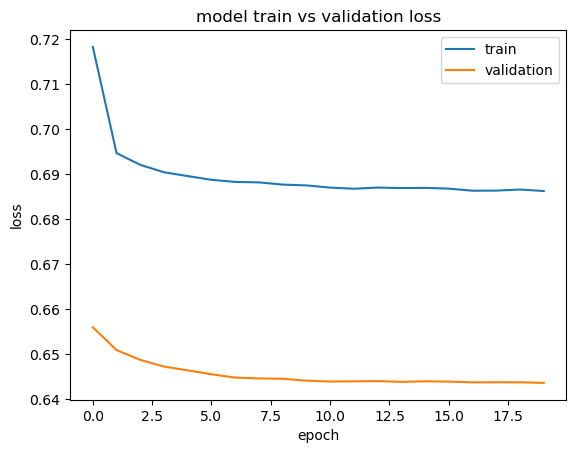

CPU times: total: 2h 45min 19s
Wall time: 12min 35s


In [12]:
%%time 
if RUN_TRAINING:

    # date splitting
    split = df_full['date_id'] > SPLIT_DAY
    df_train = df_full[~split]
    df_valid = df_full[split]

    # feature building
    df_train_features = build_features(df_train)
    df_valid_features = build_features(df_valid)

    # data scaling
    scaler = StandardScaler()
    train_features = scaler.fit_transform(df_train_features)
    valid_features = scaler.transform(df_valid_features)

    # Windowed datasets
    train_dataset = windowed_dataset(train_features, N_LAGS, BATCH_SIZE)
    valid_dataset = windowed_dataset(valid_features, N_LAGS, BATCH_SIZE)

    # model building
    model = build_model()

    # early stopping
    early_stopping = EarlyStopping(monitor='val_loss',
                      mode='min',
                      patience=PATIENCE,
                      restore_best_weights=True,
                      verbose=True)

    # model training
    history = model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        callbacks=[early_stopping],
                        verbose=True)

    ## Evaluate ## 
    y_pred = model.predict(valid_dataset)

    y_pred = scaler.inverse_transform(y_pred)
    y_true = df_valid_features[N_LAGS:]

    mae = mean_absolute_error(y_true, y_pred)
    print(f"MAE score: {mae}")

    ## Plots ##
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

#### Deep dive per stock

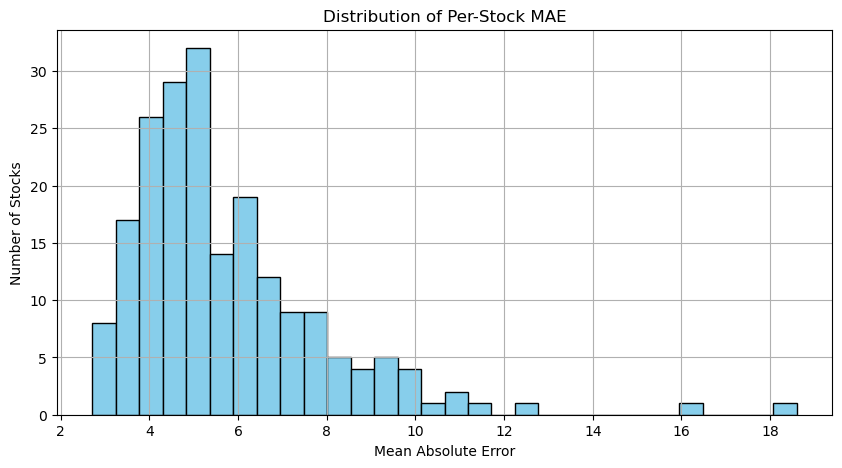

In [14]:
per_stock_mae = np.mean(np.abs(y_true - y_pred), axis=0)

plt.figure(figsize=(10, 5))
plt.hist(per_stock_mae, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Per-Stock MAE")
plt.xlabel("Mean Absolute Error")
plt.ylabel("Number of Stocks")
plt.grid(True)
plt.show()


In [15]:
# Directional accuracy
direction_accuracy = np.mean(np.sign(y_true) == np.sign(y_pred))
print(f"Directional Accuracy: {direction_accuracy:.4f}")


Directional Accuracy: 0.6091


In [16]:
worst_stocks = np.argsort(per_stock_mae)[-5:][::-1]
print("Top 5 worst-predicted stocks:\n", worst_stocks)

Top 5 worst-predicted stocks:
 199     31
198     82
197     86
196     92
195    100
dtype: int64


In [17]:
# Best Single Stock

# Convert to DataFrames for convenience
y_pred_df = pd.DataFrame(y_pred, columns=df_valid_features.columns)
y_true_df = pd.DataFrame(y_true.values, columns=df_valid_features.columns)

# Calculate MAE for each individual stock (column)
per_stock_mae = (y_pred_df - y_true_df).abs().mean()

# Get best performance and the stock ID
best_mae = per_stock_mae.min()
best_stock_id = per_stock_mae.idxmin()

print(f"Best stock MAE: {best_mae:.2f} (Stock ID: {best_stock_id})")

Best stock MAE: 2.71 (Stock ID: 112)
